In [1]:
# %%
from __future__ import print_function, division

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from utils import create_confusion_matrix

cudnn.benchmark = True
plt.ion()   # interactive mode

# %%
# Data augmentation and normalization for training
data_transforms = {
        
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Data loading
data_dir = 'flower'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



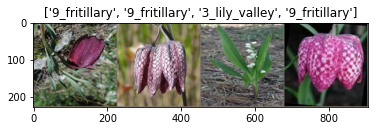

In [2]:
# ### Visualize a few images
# Let's visualize a few training images so as to understand the data
# augmentations. 
# %%
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
# ## Training the model
# %%
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    x_epoch = np.arange(num_epochs)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                fig = create_confusion_matrix(y_pred = outputs.detach().cpu().numpy(), y_true = labels.data.cpu().numpy())
                fig.save('confusion_matrix.jpg')
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.cpu())
            

            '''
            elif phase == 'test':
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc.cpu())
            '''
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        fig = plt.figure()
        ax0 = fig.add_subplot(121, title="loss")
        ax1 = fig.add_subplot(122, title="top1acc")

        ax0.plot(x_epoch[:epoch + 1], train_loss, 'b-', label = 'train')
        ax0.plot(x_epoch[:epoch + 1], val_loss, 'r-', label = 'val')
        #ax0.plot(x_epoch, test_loss, 'g-', label = 'test')
        ax1.plot(x_epoch[:epoch + 1], train_acc, 'b-', label = 'train')
        ax1.plot(x_epoch[:epoch + 1], val_acc, 'r-', label = 'val')
        #ax1.plot(x_epoch, test_acc, 'g-', label = 'test')
        
        ax0.legend()
        ax1.legend()
        fig.savefig(os.path.join('./lossGraphs', f'train_VGG.jpg'))
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# ### Visualizing the model predictions
# Generic function to display predictions for a few images
# %%
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# %% [markdown]
# Load a pretrained model and reset final fully connected layer.
# %%
model = models.vgg16(pretrained=False)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.005, momentum=0.9)



#optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9)
optimizer_ft = torch.optim.Adam(model.parameters(), lr= 5e-06)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.5)

# %%


# %% [markdown]
# ### Train and evaluate
# %%
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs=50)

/home/MUTOWORLD/anaconda3/envs/python3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/MUTOWORLD/anaconda3/envs/python3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/49
----------


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

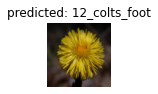

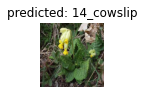

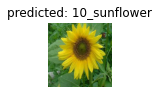

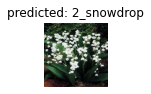

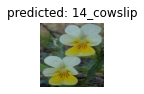

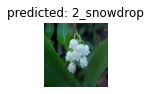

In [ ]:
# %%
visualize_model(model_ft)